In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.utils import shuffle

from xgboost import XGBRegressor
from IPython.display import clear_output
import torch
from torch import nn 
import itertools
import tensorflow
from tensorflow.python.keras.layers import Input, Dense
from tensorflow.python.keras.models import Model
import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel


import warnings
warnings.filterwarnings("ignore")

In [2]:
### read all the simulation data with different properties
df1 = pd.read_csv("Data/FE_constAng3_29param.csv")

df2 = pd.read_csv("Data/FE_Var_SizeAngle3_29param.csv")

df3 = pd.read_csv("Data/FE_Var_SizeConstAng3_29param.csv")

df4 = pd.read_csv("Data/FE_varAng3_29param.csv")

### As there are 15 repeated cases it makes the resullts better,
### wich might not be case, unless we group them touse the mean value of different trials
df9 = pd.read_csv("Data/FE_repeat01_29param.csv")

# df_total = pd.concat([df1, df2, df3, df4, df9 , 
#                        ], axis = 0, ignore_index = True)


df5 = pd.read_csv("Data/FE_constAng5_29param.csv")

df6 = pd.read_csv("Data/FE_varAng5_29param.csv")

df7 = pd.read_csv("Data/FE_constAng7_29param.csv")

df8 = pd.read_csv("Data/FE_varAng7_29param.csv")

df10 = pd.read_csv("Data/FE_repeat2_29param.csv") 

df11 = pd.read_csv("Data/FE_repeat3_29param.csv") 
# ##############################################
df_total = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8 ,df9 , df10, df11
                       ], axis = 0, ignore_index = True)



# df = df_total.groupby(['Number_pieces', 'Length_ratio','angle1_9p', 'angle2_9', 'angle3_9p', 'angle4_9p'
#                                ,'angle1_25p', 'angle2_25p', 'angle3_25p',
#                                'angle4_25p','angle5_25p', 'angle6_25p','angle1_49p', 'angle2_49p',
#                                'angle3_49p','angle4_49p','angle5_49p', 'angle6_49p', 'angle7_49p',
#                                'angle8_49p'
#                               ], as_index=False)

df = shuffle(df_total)
df.shape

(135, 29)

In [3]:
df.keys()

Index(['Number_pieces', 'Length_ratio', 'angle1_9p', 'angle2_9', 'angle3_9p',
       'angle4_9p', 'angle1_25p', 'angle2_25p', 'angle3_25p', 'angle4_25p',
       'angle5_25p', 'angle6_25p', 'angle1_49p', 'angle2_49p', 'angle3_49p',
       'angle4_49p', 'angle5_49p', 'angle6_49p', 'angle7_49p', 'angle8_49p',
       'Safety_factor', 'Oop_deform', 'Tot_contactEngy', 'Elast_strainEngy',
       'Edge_temp', 'Avr_frictForce', 'HeatRate', 'IntEngy', 'FricDissipRate'],
      dtype='object')

In [4]:
# print(
#     df.loc[(df.FricDissipRate > 4)].index[0], 
# #     df.loc[(df.Safety_factor < 0.015)].index[0], 
#       df.loc[(df.Tot_contactEngy > 50)].index[0],
#     df.loc[(df.Elast_strainEngy > 15)].index[0]
# )

In [5]:
# df_filtered = df.drop([
# #     df.loc[(df.Safety_factor < 0.015)].index[0],
#                       df.loc[(df.FricDissipRate > 4)].index[0],
#                       df.loc[(df.Tot_contactEngy > 50)].index[0]
#                       ], axis = 0)
# df = df_filtered.reset_index(drop=True)

In [6]:
# ###------- normalizing data 
normalizer = MinMaxScaler()
df_norm = normalizer.fit_transform(df)

df = pd.DataFrame(df_norm, columns=df.columns )
# print(df.keys())

In [7]:
# df_clean3 = df.drop(df.iloc[:,6:20], axis = 'columns')
# X = df.iloc[:, 1:6]
X = df.iloc[:, 0:20]

# X

## We define all the models in functions to be able to call them multiple times and for different outputs. 
**The hyperparameters for each output has been determined through grid search in another notebook over all the input parameters for 3 by 3 pannel**

In [8]:
def Hyperparam(output):
    if output == 'Safety_factor' :
        Y1 = df.iloc[:, 20:21]
        hyperparams = [0.5, 0.01 , 3, 100, 1]
    elif output == 'Oop_deform' : 
        Y1 = df.iloc[:, 21:22] 
        hyperparams = [1, 0.5, 7, 20, 0.632]
    elif output == 'Tot_contactEngy' : 
        Y1 = df.iloc[:, 22:23]
        hyperparams = [0.1, 0.1, 3, 20, 0.632]
    elif output == 'Elast_strainEngy':
        Y1 = df.iloc[:, 23:24] 
        hyperparams = [0.1, 0.01, 3, 100, 1]
    elif output == 'Edge_temp':
        Y1 = df.iloc[:, 24:25]
        hyperparams = [0.5, 0.5, 3, 20, 0.632]
    elif output == 'Avr_frictForce':
        Y1 = df.iloc[:, 25:26]
        hyperparams = [1, 0.5, 5, 50, 0.632]
    elif output == 'HeatRate':
        Y1 = df.iloc[:, 26:27]
        hyperparams = [1, 0.1, 3, 50, 1]
    elif output == 'IntEngy':
        Y1 = df.iloc[:, 27:28]
        hyperparams = [1, 0.5, 7, 50, 0.632]
    elif output == 'FricDissipRate':
        Y1 = df.iloc[:, 28:29]
        hyperparams = [0.5, 0.1, 7, 50, 1]
    return Y1, hyperparams

In [9]:
""" Define different models"""

def MODELS(model_name, output):
    Y1, hyperparams = Hyperparam(output)
    if model_name == 'model1' : 
        model = Pipeline([
            ('linear_regression', LinearRegression())
        ])
    elif model_name == 'model2' :
        model = Pipeline([   # higher degree might causes overfitting
            ('poly', PolynomialFeatures(degree=2, include_bias=False)), 
            ('linear_regression', LinearRegression())
        ])

    elif model_name == 'model3' :
        model = Pipeline([   
            ('poly', PolynomialFeatures(degree=3, include_bias=False)), 
            ('linear_regression', LinearRegression())
        ])
        
    elif model_name == 'model4' :
        model = Pipeline([   
            ('poly', PolynomialFeatures(degree=4, include_bias=False)), 
            ('linear_regression', LinearRegression())
        ])

    elif model_name == 'model5' :
        ## XGB on original standardized inputs
        model = Pipeline([
            ('XGB', XGBRegressor(max_depth=hyperparams[2],                 # Depth of each tree
                            learning_rate=hyperparams[1],            # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                            n_estimators=hyperparams[3],             # How many trees to use, the more the better, but decrease learning rate if many used.
                            verbosity=1,                  # If to show more errors or not.
                            objective='reg:squarederror',  # Type of target variable. for classifieer use 'binary:logistic'
                            n_jobs=4,                     # Parallel jobs to run. Set your processor number.
                            gamma=0.001,                  # Minimum loss reduction required to make a further partition on a leaf node of the tree. (Controls growth!)
                            subsample=hyperparams[4],              # Subsample ratio. Can set lower than 1. If we want perfect boosting
                            colsample_bytree=1,           # Subsample ratio of columns when constructing each tree.
                            colsample_bylevel=1,          # Subsample ratio of columns when constructing each level. 0.33 is similar to random forest. sqrt(no.var)
                            colsample_bynode=1,           # Subsample ratio of columns when constructing each split.
                            scale_pos_weight=0.5,           # Balancing of positive and negative weights.
                            base_score=hyperparams[0],               # Global bias. Set to average of the target rate.
                            random_state=20210614,        # Seed
                            missing=1                  # How are nulls encoded?
                            ))
        ])

    elif model_name == 'model6' :
        ### XGB on 2nd order polynomial of inputs
        model = Pipeline([
            ('poly', PolynomialFeatures(degree=2, include_bias=False)),
            ('XGB', XGBRegressor(max_depth=hyperparams[2],                 # Depth of each tree
                            learning_rate=hyperparams[1],            # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                            n_estimators=hyperparams[3],             # How many trees to use, the more the better, but decrease learning rate if many used.
                            verbosity=1,                  # If to show more errors or not.
                            objective='reg:squarederror',  # Type of target variable. for classifieer use 'binary:logistic'
                            n_jobs=4,                     # Parallel jobs to run. Set your processor number.
                            gamma=0.001,                  # Minimum loss reduction required to make a further partition on a leaf node of the tree. (Controls growth!)
                            subsample=hyperparams[4],              # Subsample ratio. Can set lower than 1. If we want perfect boosting
                            colsample_bytree=1,           # Subsample ratio of columns when constructing each tree.
                            colsample_bylevel=1,          # Subsample ratio of columns when constructing each level. 0.33 is similar to random forest. sqrt(no.var)
                            colsample_bynode=1,           # Subsample ratio of columns when constructing each split.
                            scale_pos_weight=0.5,           # Balancing of positive and negative weights.
                            base_score=hyperparams[0],               # Global bias. Set to average of the target rate.
                            random_state=20210614,        # Seed
                            missing=1                  # How are nulls encoded?
                            ))
        ])

    elif model_name == 'model7' :
        ### XGB on 3rd order polynomial of inputs
        model = Pipeline([
            ('poly', PolynomialFeatures(degree=3, include_bias=False)),
            ('XGB', XGBRegressor(max_depth=hyperparams[2],                 # Depth of each tree
                            learning_rate=hyperparams[1],            # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                            n_estimators=hyperparams[3],             # How many trees to use, the more the better, but decrease learning rate if many used.
                            verbosity=1,                  # If to show more errors or not.
                            objective='reg:squarederror',  # Type of target variable. for classifieer use 'binary:logistic'
                            n_jobs=4,                     # Parallel jobs to run. Set your processor number.
                            gamma=0.001,                  # Minimum loss reduction required to make a further partition on a leaf node of the tree. (Controls growth!)
                            subsample=hyperparams[4],              # Subsample ratio. Can set lower than 1. If we want perfect boosting
                            colsample_bytree=1,           # Subsample ratio of columns when constructing each tree.
                            colsample_bylevel=1,          # Subsample ratio of columns when constructing each level. 0.33 is similar to random forest. sqrt(no.var)
                            colsample_bynode=1,           # Subsample ratio of columns when constructing each split.
                            scale_pos_weight=0.5,           # Balancing of positive and negative weights.
                            base_score=hyperparams[0],               # Global bias. Set to average of the target rate.
                            random_state=20210614,        # Seed
                            missing=1                  # How are nulls encoded?
                            ))
        ])
    return model

In [10]:
"""Cross validation error on all the data"""

def cv_loss(Xtrain, Ytrain, output):
    kf = KFold(n_splits=10)
    print('Train cross validation loss on ',str(output),'for different models:')

    #################################################
    print('\nLinear regression:')
    print((-cross_val_score(MODELS('model1', output), Xtrain, Ytrain,
                          cv=kf, scoring='neg_mean_squared_error').mean()).round(6)*100,'%')

    #####################

    print('\n2nd order Polynomial + LR:')
    print((-cross_val_score(MODELS('model2', output), Xtrain, Ytrain,
                          cv=kf, scoring='neg_mean_squared_error').mean()).round(6)*100,'%')

    ########################    

    print('\n3rd order Polynomial + LR:')
    print((-cross_val_score(MODELS('model3', output), Xtrain, Ytrain,
                          cv=kf, scoring='neg_mean_squared_error').mean()).round(6)*100,'%')

    ########################

    print('\n4th order Polynomial + LR:')
    print((-cross_val_score(MODELS('model4', output), Xtrain, Ytrain,
                          cv=kf, scoring='neg_mean_squared_error').mean()).round(6)*100,'%')

    ########################

    print('\nXGB:')
    print((-cross_val_score(MODELS('model5', output), Xtrain, Ytrain,
                            cv=kf, scoring='neg_mean_squared_error').mean()).round(6)*100,'%')

    ##################

    print('\n2nd order Polynomial + XGB:')
    print((-cross_val_score(MODELS('model6', output), Xtrain, Ytrain,
                            cv=kf, scoring='neg_mean_squared_error').mean()).round(6)*100,'%')

    ##################

    print('\n3rd order Polynomial + XGB:')
    print((-cross_val_score(MODELS('model7', output), Xtrain, Ytrain,
                            cv=kf, scoring='neg_mean_squared_error').mean()).round(6)*100,'%')

## Comparing cross-validation error of different models on all the data

In [11]:
OUTPUTS = ['Safety_factor', 'Oop_deform', 'Tot_contactEngy', 'Elast_strainEngy',
       'Edge_temp', 'Avr_frictForce', 'HeatRate', 'IntEngy', 'FricDissipRate']

for output in OUTPUTS:
    Y1, hyperparams = Hyperparam(output)
    cv_loss(X, Y1, output)
    print('***********************************************************')

Train cross validation loss on  Safety_factor for different models:

Linear regression:
1.8886 %

2nd order Polynomial + LR:
15.711400000000001 %

3rd order Polynomial + LR:
6.5038965036043865e+22 %

4th order Polynomial + LR:
7.051499999999999 %

XGB:
1.7878999999999998 %

2nd order Polynomial + XGB:
1.8904 %

3rd order Polynomial + XGB:
1.8223 %
***********************************************************
Train cross validation loss on  Oop_deform for different models:

Linear regression:
1.8388000000000002 %

2nd order Polynomial + LR:
3.6558 %

3rd order Polynomial + LR:
1.0199175813557321e+23 %

4th order Polynomial + LR:
4.6121 %

XGB:
0.6668000000000001 %

2nd order Polynomial + XGB:
0.8170999999999999 %

3rd order Polynomial + XGB:
0.9124 %
***********************************************************
Train cross validation loss on  Tot_contactEngy for different models:

Linear regression:
1.8064 %

2nd order Polynomial + LR:
0.7983 %

3rd order Polynomial + LR:
3.817628617503892e

In [13]:
def modelPerformance(X, Y1, output):
    losses = []
    R2es = []

    models = {'LR': MODELS('model1', output), 
              '2poly_LR': MODELS('model2', output), '3poly_LR': MODELS('model3', output), #'4poly_LR': model4,
              'XGB': MODELS('model5', output), '2poly_XGB': MODELS('model6', output), 
              '3poly_XGB': MODELS('model7', output),}

    n = 100   # how many different test-train splits
    for key, value in models.items():

        losses = []
        R2es = []
        t = time.process_time()

        for i in range(n):
            X_train, X_test,Y_train, Y_test, = train_test_split(X, Y1 , test_size = 0.20)
            Models = value.fit(X_train, Y_train)
            predict = Models.predict(X_test)
            loss = mean_squared_error(Y_test, predict)
            R2 = r2_score(Y_test, predict)
            losses.append(loss)
            R2es.append(R2)

        elapsed_time = time.process_time() - t
        print('Avr. test loss on ',str(output),'for different models:')
        print('Avr. MSE for: ',key ,' = ', (np.mean(np.array(losses))*100).round(6))
        print('Avr. R2 for: ',key ,' = ', (np.mean(np.array(R2es))*100).round(6),' %')
        print('time for each split: ',round(elapsed_time/n, 6), 's \n*********\n')

## Comparing performance of different models for 100 different train-test splits

In [14]:
OUTPUTS = ['Safety_factor', 'Oop_deform', 'Tot_contactEngy', 'Elast_strainEngy',
       'Edge_temp', 'Avr_frictForce', 'HeatRate', 'IntEngy', 'FricDissipRate']

for output in OUTPUTS:
    Y1, hyperparams = Hyperparam(output)
    modelPerformance(X, Y1, output)
    print('***********************************************************')

Avr. test loss on  Safety_factor for different models:
Avr. MSE for:  LR  =  11.571911
Avr. R2 for:  LR  =  -154.290568  %
time for each split:  0.005392 s 
*********

Avr. test loss on  Safety_factor for different models:
Avr. MSE for:  2poly_LR  =  4.175674996782842e+21
Avr. R2 for:  2poly_LR  =  -2.549444993306401e+23  %
time for each split:  0.035969 s 
*********

Avr. test loss on  Safety_factor for different models:
Avr. MSE for:  3poly_LR  =  1.6619897562271192e+21
Avr. R2 for:  3poly_LR  =  -3.915799255065464e+22  %
time for each split:  0.129008 s 
*********

Avr. test loss on  Safety_factor for different models:
Avr. MSE for:  XGB  =  1.631264
Avr. R2 for:  XGB  =  55.302715  %
time for each split:  0.11298 s 
*********

Avr. test loss on  Safety_factor for different models:
Avr. MSE for:  2poly_XGB  =  1.637175
Avr. R2 for:  2poly_XGB  =  55.852247  %
time for each split:  0.216498 s 
*********

Avr. test loss on  Safety_factor for different models:
Avr. MSE for:  3poly_XGB 

Avr. test loss on  IntEngy for different models:
Avr. MSE for:  2poly_LR  =  1.5998355492363517e+21
Avr. R2 for:  2poly_LR  =  -2.2613894480649565e+22  %
time for each split:  0.034317 s 
*********

Avr. test loss on  IntEngy for different models:
Avr. MSE for:  3poly_LR  =  2.2907904101875024e+23
Avr. R2 for:  3poly_LR  =  -2.784368578940277e+24  %
time for each split:  0.139165 s 
*********

Avr. test loss on  IntEngy for different models:
Avr. MSE for:  XGB  =  1.183926
Avr. R2 for:  XGB  =  82.360125  %
time for each split:  0.115429 s 
*********

Avr. test loss on  IntEngy for different models:
Avr. MSE for:  2poly_XGB  =  1.207949
Avr. R2 for:  2poly_XGB  =  81.619656  %
time for each split:  0.206078 s 
*********

Avr. test loss on  IntEngy for different models:
Avr. MSE for:  3poly_XGB  =  1.182611
Avr. R2 for:  3poly_XGB  =  82.346377  %
time for each split:  0.616197 s 
*********

***********************************************************
Avr. test loss on  FricDissipRate fo

## Checking NN results

In [9]:
def NN_MultiLayer(Xtrain, Y_train, Xtest, Y_test):
#     tensorflow.random.set_seed(20210614)   # to fix initial coeficients 
    input = Input(shape=(20,))
    x = Dense(64, activation='relu')(input)
    x = Dense(32, activation='relu')(x)
    output = Dense(1)(x)
    model = Model(inputs=input, outputs=output)
    model.compile(optimizer='adam', loss='mse')

    model.fit(Xtrain, (Y_train) , epochs=500, batch_size=32 ,verbose=0)
    pred = model.predict(Xtest)

    error = (mean_squared_error(pred, Y_test)).round(3)
    Rsquare = (r2_score(pred, Y_test)).round(3)
    return error , Rsquare

In [10]:
def nnModel(X, Y1):
    losses = []
    R2es = []
    t = time.process_time()
    n = 100
    for i in range(n):
        X_train, X_test,Y_train, Y_test = train_test_split(X, Y1 , test_size = 0.20)
        loss, R2 = NN_MultiLayer(X_train, Y_train, 
                                 X_test, Y_test)
        losses.append(loss)
        R2es.append(R2)

    elapsed_time = time.process_time() - t  

    print('\nMSE for NN is: ', np.mean(np.array(losses))*100)
    print('R2 for NN is: ', np.mean(np.array(R2es))*100, ' %')
    print('time: ',round(elapsed_time/n, 6), '\n*********\n')

## NN performances for different outputs

In [11]:
OUTPUTS = ['Safety_factor', 'Oop_deform', 'Tot_contactEngy', 'Elast_strainEngy',
       'Edge_temp', 'Avr_frictForce', 'HeatRate', 'IntEngy', 'FricDissipRate']

for output in OUTPUTS:
    Y1, hyperparams = Hyperparam(output)
    nnModel(X, Y1)
    print('***********************************************************')

2022-03-28 15:05:41.456092: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-28 15:05:41.548757: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)



MSE for NN is:  1.8239999999999998
R2 for NN is:  45.768  %
time:  2.384132 
*********

***********************************************************

MSE for NN is:  0.688
R2 for NN is:  80.73700000000001  %
time:  2.646915 
*********

***********************************************************

MSE for NN is:  0.539
R2 for NN is:  82.01800000000001  %
time:  2.388354 
*********

***********************************************************

MSE for NN is:  0.4280000000000001
R2 for NN is:  82.16700000000002  %
time:  2.663495 
*********

***********************************************************

MSE for NN is:  0.868
R2 for NN is:  87.448  %
time:  3.093074 
*********

***********************************************************

MSE for NN is:  1.311
R2 for NN is:  62.99199999999999  %
time:  2.948819 
*********

***********************************************************

MSE for NN is:  1.5739999999999996
R2 for NN is:  70.93599999999998  %
time:  2.781356 
*********

**************

In [21]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

def GP1(output,X, Y1):
    losses = []
    R2es = []

    for i in range(100):
        X_train, X_test,Y_train, Y_test = train_test_split(X, Y1 , test_size = 0.20)

        kernel = 1 * RBF()

        gaussian_process = GaussianProcessRegressor(kernel=kernel,
                                                alpha=0,
                                                    )
        gaussian_process.fit(X_train, Y_train)
    #     gaussian_process.kernel_
        mean_prediction, std_prediction = gaussian_process.predict(X_test, return_std=True)

        loss = (mean_squared_error(Y_test, mean_prediction)).round(3)
        R2 = (r2_score(Y_test, mean_prediction)).round(3)
        losses.append(loss)
        R2es.append(R2)
 
    return losses, R2es

In [22]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF


def GP2(output,X, Y1):
    losses = []
    R2es = []

    for i in range(100):
        X_train, X_test,Y_train, Y_test = train_test_split(X, Y1 , test_size = 0.20)

        kernel = 1 * RBF(length_scale=1.0,length_scale_bounds=(1e-2, 1e2))

        gaussian_process = GaussianProcessRegressor(kernel=kernel,
                                                    n_restarts_optimizer=9,
                                                    alpha=0)
        gaussian_process.fit(X_train, Y_train)
    #     gaussian_process.kernel_
        mean_prediction, std_prediction = gaussian_process.predict(X_test, return_std=True)

        loss = (mean_squared_error(Y_test, mean_prediction)).round(3)
        R2 = (r2_score(Y_test, mean_prediction)).round(3)
        losses.append(loss)
        R2es.append(R2)
    return losses, R2es    

In [12]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel



def GP(output,X, Y1):
    losses = []
    R2es = []

    for i in range(100):
        X_train, X_test,Y_train, Y_test = train_test_split(X, Y1 , test_size = 0.20)
        
        kernel = ConstantKernel(1.0) +\
                ConstantKernel(1.0) * RBF(length_scale=1.0,length_scale_bounds=(1e-2, 1e2)) +\
                WhiteKernel(5)
        model = GaussianProcessRegressor(kernel=kernel)
        model.fit(X_train, Y_train)
        
        y_pred_tr, y_pred_tr_std = model.predict(X_train, return_std=True)
        y_pred_te, y_pred_te_std = model.predict(X_test, return_std=True)

        loss = (mean_squared_error(Y_test, y_pred_te)).round(3)*100
        R2 = (r2_score(Y_test, y_pred_te)).round(3)*100
        losses.append(loss)
        R2es.append(R2)

    return losses, R2es

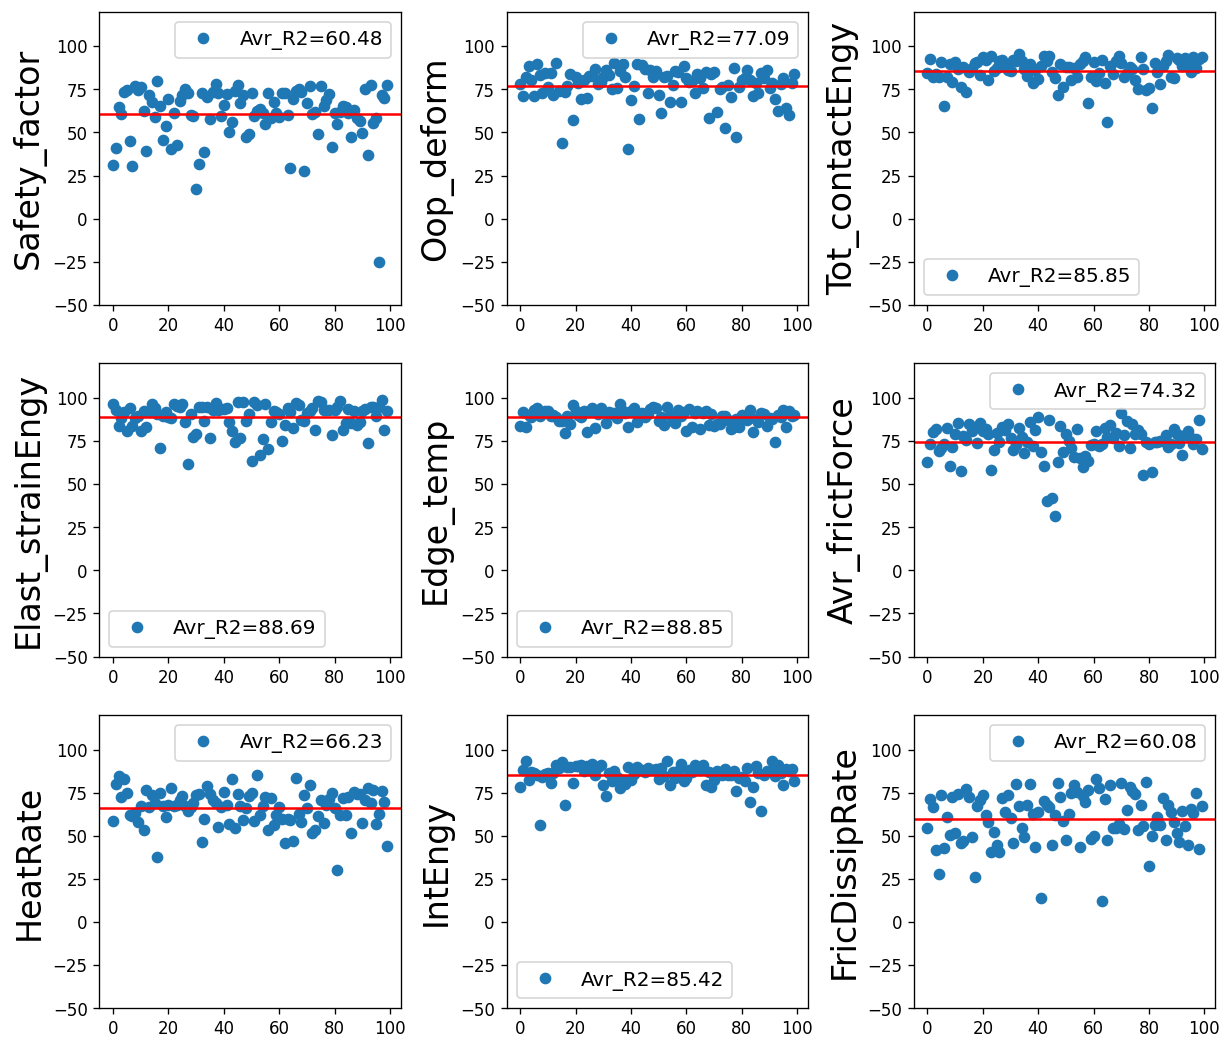

In [13]:
OUTPUTS = ['Safety_factor', 'Oop_deform', 'Tot_contactEngy', 'Elast_strainEngy',
       'Edge_temp', 'Avr_frictForce', 'HeatRate', 'IntEngy', 'FricDissipRate']


fig, axes = plt.subplots(dpi = 120,nrows = 3, ncols = 3,figsize=(12, 11))

plt.subplots_adjust(hspace = 0.2, wspace=0.35)  #determines the distance between two rows of plots

"""flattens the ax variable, if we don't do that we can not put it in the for loop."""
ax = axes.ravel() 


for output, a in zip(OUTPUTS,ax):
    Y1, hyperparams = Hyperparam(output)
    loss, R2 = GP(output, X, Y1)
#     a.hist(R2, bins= 50, label='Avr.R2=\n'+str(round(np.array(R2).mean(),2))+'%')
#     a.set_ylabel(output, fontsize=20)
#     a.set_xlabel('R2', fontsize=15)
    a.plot(R2, 'o', label='Avr_R2='+str(round(np.array(R2).mean(),2)))
    a.axhline(y=np.array(R2).mean(), color='r', linestyle='-')
    a.set_ylabel(output, fontsize=20)
    a.set_ylim(-50, 120)
    a.legend(loc=0, fontsize=12)
    
#     print('***********************************************************')

# plt.savefig('CleanGraphs/GP_prediction_9_29angles_hist.png',bbox_inches='tight')

# plt.savefig('CleanGraphs/GP_prediction_9_4angles.png',bbox_inches='tight')
plt.show()

Text(0, 0.5, 'Predicted')

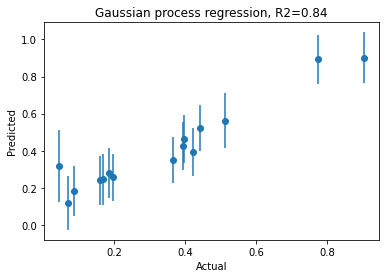

In [14]:
Y1 = df.iloc[:, 23:24]

X_train, X_test,Y_train, Y_test = train_test_split(X, Y1 , test_size = 0.20)
kernel = ConstantKernel(1.0) + ConstantKernel(1.0) * RBF(10)  + WhiteKernel(5)
model = GaussianProcessRegressor(kernel=kernel)
model.fit(X_train, Y_train)
y_pred_tr, y_pred_tr_std = model.predict(X_train, return_std=True)
y_pred_te, y_pred_te_std = model.predict(X_test, return_std=True)

plt.figure()
# plt.errorbar(Y_train.values.reshape(-1,1), y_pred_tr, yerr=y_pred_tr_std, fmt='o', color='r')


plt.errorbar(Y_test.values.reshape(-1,1), y_pred_te, yerr=y_pred_te_std, fmt='o')
plt.title('Gaussian process regression, R2=%.2f' % r2_score(Y_test, y_pred_te))
plt.xlabel('Actual')
plt.ylabel('Predicted')

(array([2., 3., 3., 2., 1., 2., 0., 0., 0., 2.]),
 array([0.11938622, 0.19769968, 0.27601313, 0.35432659, 0.43264004,
        0.5109535 , 0.58926695, 0.66758041, 0.74589386, 0.82420732,
        0.90252078]),
 <BarContainer object of 10 artists>)

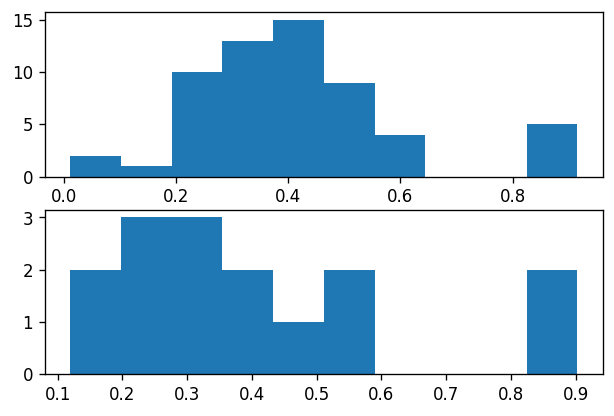

In [22]:
fig, axes = plt.subplots(dpi = 120,nrows =2, ncols = 1)

# plt.subplots_adjust(hspace = 0.2, wspace=0.35) 
ax = axes.ravel() 

ax[0].hist(y_pred_tr)
ax[1].hist(y_pred_te)